In [4]:
from IPython.display import clear_output
import matplotlib.backends.backend_pdf
from tqdm.notebook import tqdm
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import scvelo as scv
scv.settings.verbosity=1

import os
at_home = False if '/fast/work/users/' in os.getcwd() else True
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
tmp_path = '/fast/scratch/users/peidlis_c/tmp/'
import sys
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *
data_path = '/extra/stefan/public_data/' if at_home else '/fast/work/users/peidlis_c/data/'

from scipy.io import mmread
from scipy.sparse import csr_matrix

%matplotlib inline

/tmp/ipykernel_2652098/472420739.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# LiaoZhang120520

In [23]:
path = 'data/LiaoZhang120520/'
samples = [f.replace('_filtered_feature_bc_matrix.h5', '') for f in get_files(path, False) if 'filtered_feature_bc_matrix' in f]
BALFs = ['C141', 'C142', 'C143', 'C144', 'C145', 'C146',
        'C51', 'C52', 'C100', 'C148', 'C149', 'C152']
patient_group = ['mild COVID19', 'mild COVID19', 'severe COVID19', 'mild COVID19', 'severe COVID19', 'severe COVID19',
                'healthy', 'healthy', 'healthy', 'severe COVID19', 'severe COVID19', 'severe COVID19']
group_dict = dict(zip(BALFs, patient_group))

adatas = {}
for sample in tqdm(samples):
    patient = sample.split('_')[-1]
    condition = group_dict[patient]
    adata = sc.read_10x_h5(f'{path}{sample}_filtered_feature_bc_matrix.h5')
    adata.obs['condition'] = condition
    adata.obs['patient']=patient
    adata.var_names_make_unique()
    adatas[patient]=adata

superdata = sc.concat(adatas, index_unique='-')
superdata.write(f'{path}LiaoZhang120520_raw.h5')

  0%|          | 0/12 [00:00<?, ?it/s]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

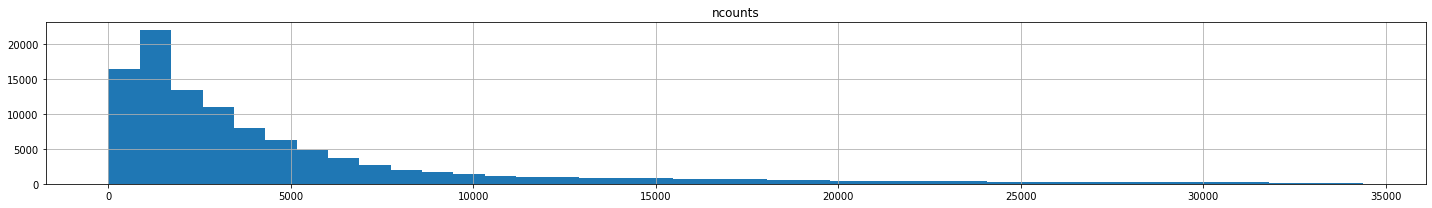

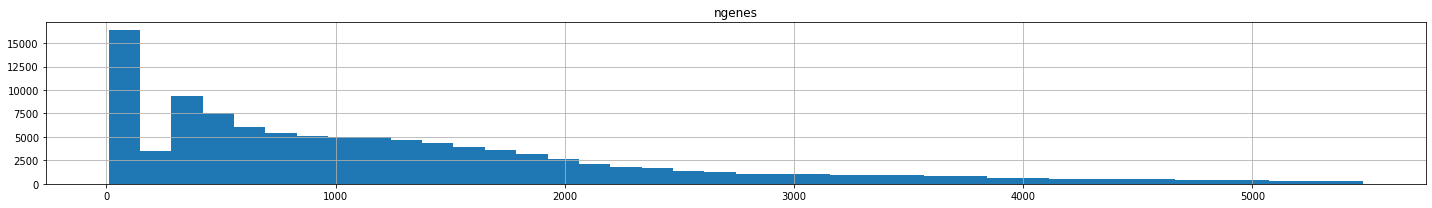

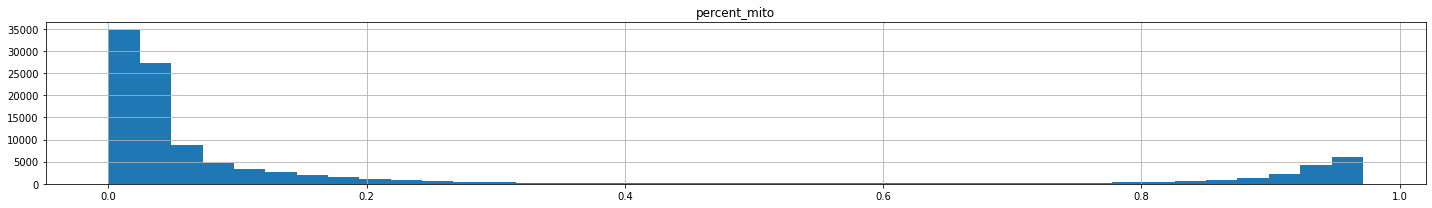

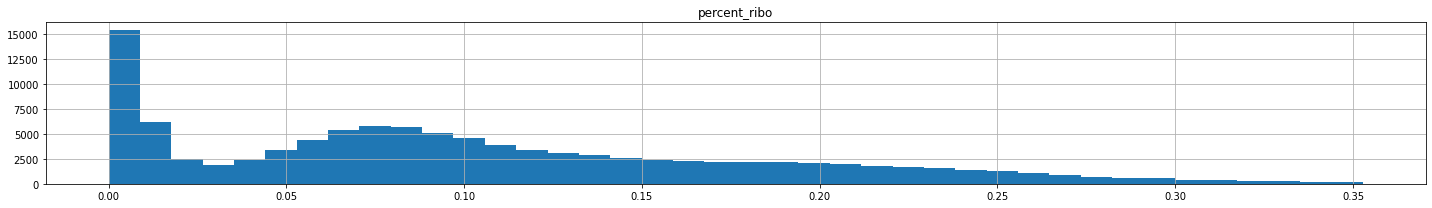

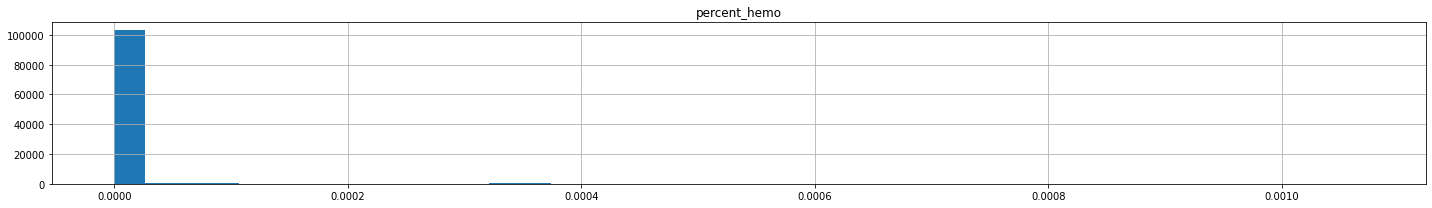

In [18]:
adata = sc.read(f'{path}LiaoZhang120520_raw.h5')
calc_qc(adata)
obs_hist(adata, ['ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'percent_hemo'])
adata=adata[adata.obs.percent_mito<0.3].copy()
adata=adata[adata.obs.ncounts<35000].copy()
adata=adata[adata.obs.ncounts>1000].copy()

In [19]:
adata.layers['counts'] = adata.X
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata)
scv.pp.pca(adata, use_highly_variable=True)
scv.pp.neighbors(adata)
scv.tl.umap(adata)

In [20]:
meta_all = pd.read_csv(f'{path}all.cell.annotation.meta.txt', sep='\t', index_col=0)
meta_all.index = [index.split('_')[0]+'-1-'+row['sample'] for index, row in meta_all.iterrows()]
meta_myeloid = pd.read_csv(f'{path}myeloid.cell.annotation.meta.txt', sep='\t', index_col=0)
meta_myeloid.index = [index.split('_')[0]+'-1-'+row['sample'] for index, row in meta_myeloid.iterrows()]
meta_t = pd.read_csv(f'{path}NKT.cell.annotation.meta.txt', sep='\t', index_col=0)
meta_t.index = [index.split('_')[0]+'-1-'+row['sample'] for index, row in meta_t.iterrows()]

meta_all = meta_all[['celltype']]
meta_fine = pd.concat([meta_t, meta_myeloid])[['celltype']].rename({'celltype': 'celltype_fine'}, axis=1)
obs_ = pd.concat([adata.obs, meta_all, meta_fine], axis=1)
adata.obs = obs_[~pd.isna(obs_.patient)]

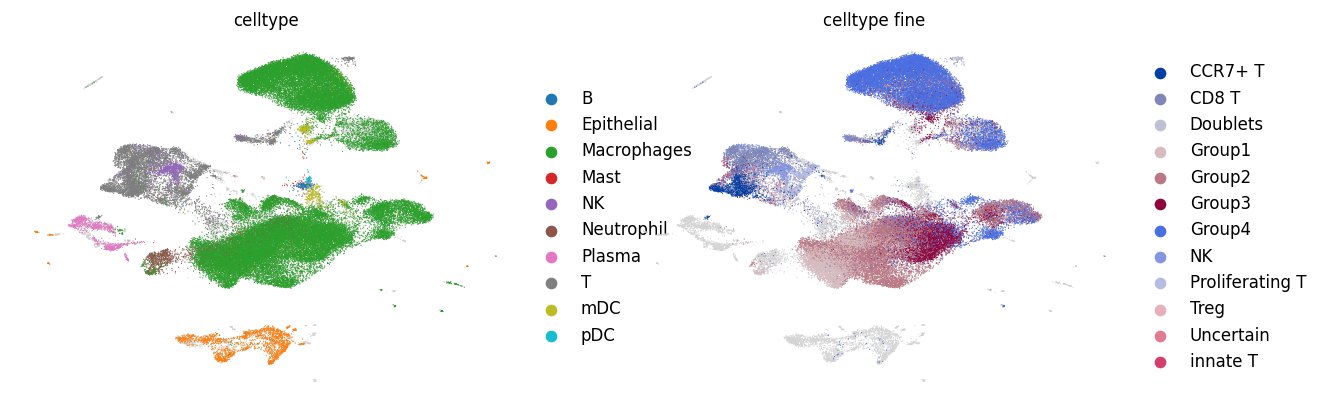

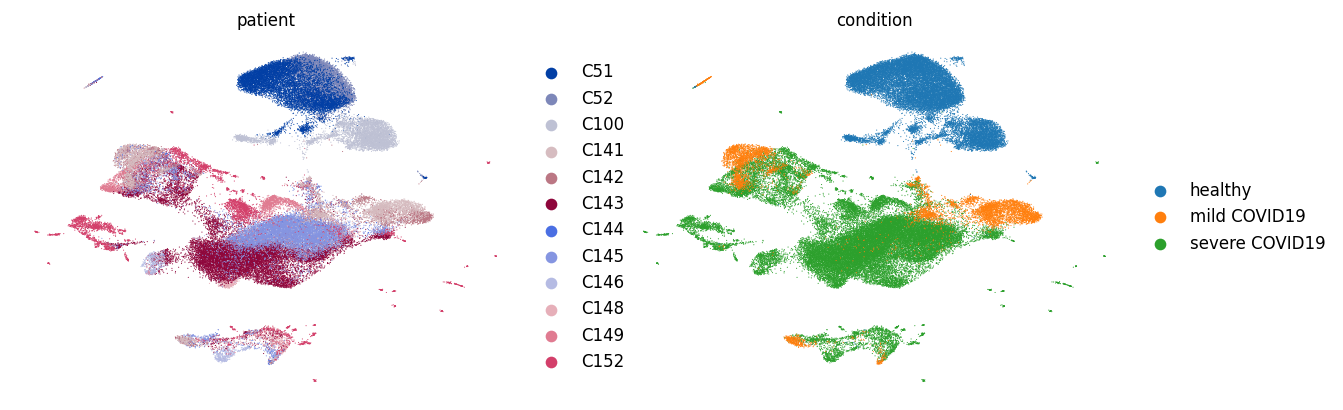

In [21]:
scv.pl.scatter(adata, color=['celltype', 'celltype_fine'], dpi=120, legend_loc='right margin')
scv.pl.scatter(adata, color=['patient', 'condition'], dpi=120, legend_loc='right margin')

2021-12-12 19:00:30,257 - harmonypy - INFO - Iteration 1 of 10
2021-12-12 19:01:04,756 - harmonypy - INFO - Iteration 2 of 10
2021-12-12 19:01:40,509 - harmonypy - INFO - Converged after 2 iterations


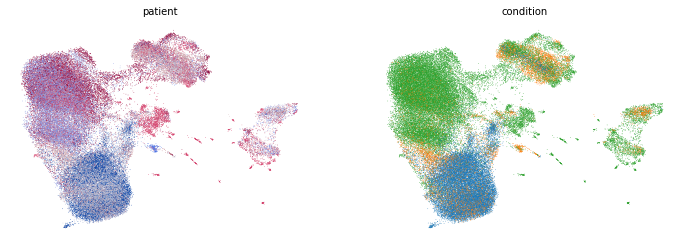

In [22]:
sc.external.pp.harmony_integrate(adata, 'patient')
scv.pp.neighbors(adata, use_rep='X_pca_harmony')
scv.tl.umap(adata)
scv.pl.scatter(adata, color=['patient', 'condition'])

In [23]:
adata.write(f'data/LiaoZhang120520/LiaoZhang120520.h5')

In [128]:
mdata = adata[adata.obs.celltype == 'Macrophages'].copy()
sc.pp.highly_variable_genes(mdata)
scv.pp.pca(mdata, use_highly_variable=True)
scv.pp.neighbors(mdata)
scv.tl.umap(mdata)
scv.pl.scatter(mdata, color=['patient', 'condition', 'celltype_fine'], dpi=120, legend_loc='right margin')
mdata.write(f'data/LiaoZhang120520/LiaoZhang120520_Macrophages.h5')

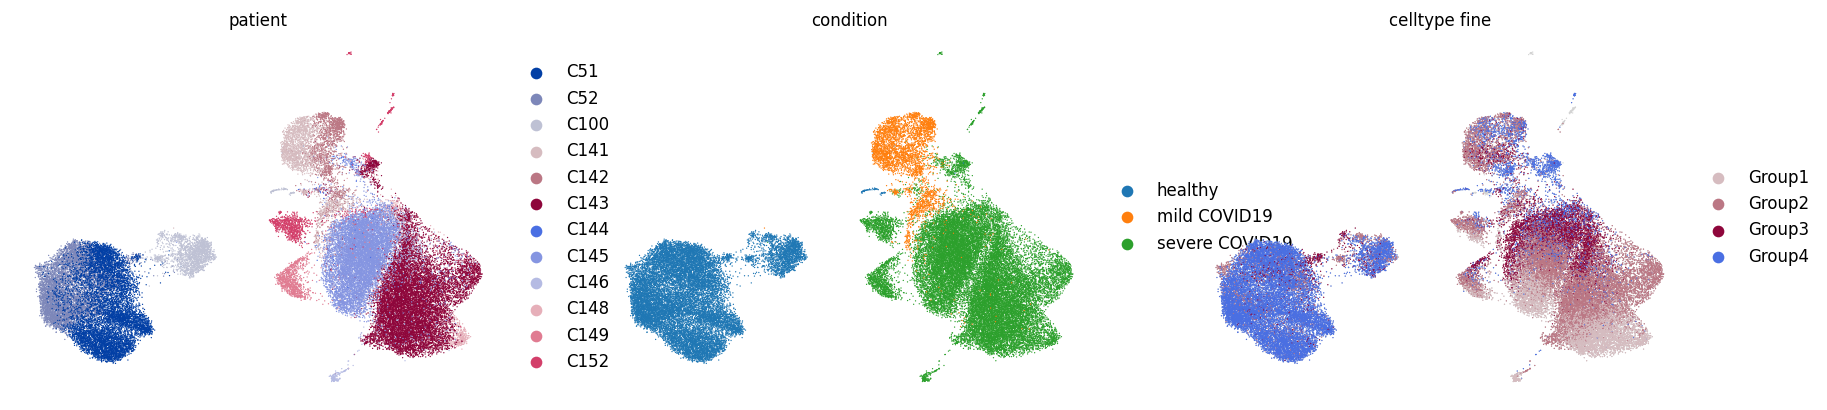

In [129]:
scv.pl.scatter(mdata, color=['patient', 'condition', 'celltype_fine'], dpi=120, legend_loc='right margin')

2021-11-16 16:31:49,755 - harmonypy - INFO - Iteration 1 of 10
2021-11-16 16:32:17,711 - harmonypy - INFO - Iteration 2 of 10
2021-11-16 16:32:45,717 - harmonypy - INFO - Converged after 2 iterations


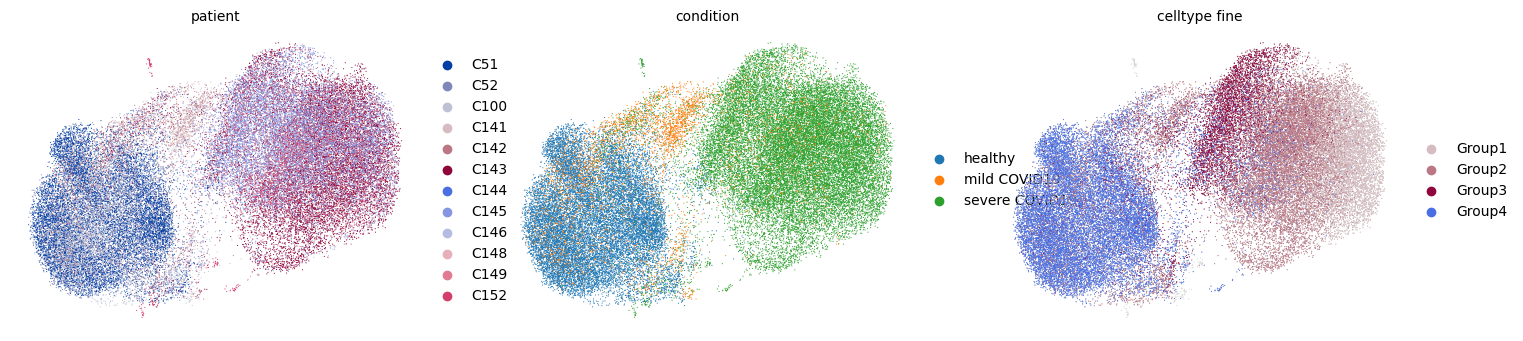

In [130]:
sc.external.pp.harmony_integrate(mdata, 'patient')
scv.pp.neighbors(mdata, use_rep='X_pca_harmony')
scv.tl.umap(mdata)
scv.pl.scatter(mdata, color=['patient', 'condition', 'celltype_fine'], dpi=100, legend_loc='right margin')

In [131]:
mdata.write(f'data/LiaoZhang120520/LiaoZhang120520_Macrophages.h5')

# MelmsIzar290421

In [ ]:
path = 'data/MelmsIzar290421/'

In [7]:
# M = pd.read_csv(f'{path}GSE171524_processed_data.csv.gz').set_index('Unnamed: 0').T  #  already scaled...

In [8]:
metadata = pd.read_csv(f'{path}GSE171524_lung_metaData.txt.gz', sep='\t', header=0).drop(0).set_index('NAME')

In [9]:
adatas = []
for file in tqdm([f for f in get_files(path, False) if '_raw_counts.csv.gz' in f]):
    data = pd.read_csv(f'{path}{file}', index_col=0).T
    adata = sc.AnnData(csr_matrix(data.values))
    adata.var_names = data.columns
    adata.obs_names = data.index
    adatas.append(adata)

 33%|███▎      | 9/27 [02:16<04:33, 15.17s/it]


KeyboardInterrupt: 

In [ ]:
superdata = sc.concat(adatas)
superdata = superdata[np.isin(list(superdata.obs_names), list(metadata.index))].copy()
superdata.obs = pd.concat([superdata.obs, metadata], axis=1)

In [258]:
superdata.write('MelmsIzar290421_raw.h5')

... storing 'biosample_id' as categorical
... storing 'donor_id' as categorical
... storing 'species' as categorical
... storing 'species__ontology_label' as categorical
... storing 'disease' as categorical
... storing 'disease__ontology_label' as categorical
... storing 'organ' as categorical
... storing 'organ__ontology_label' as categorical
... storing 'library_preparation_protocol' as categorical
... storing 'library_preparation_protocol__ontology_label' as categorical
... storing 'group' as categorical
... storing 'cell_type_main' as categorical
... storing 'cell_type_intermediate' as categorical
... storing 'cell_type_fine' as categorical
... storing 'initial_clustering' as categorical
... storing 'age' as categorical
... storing 'sex' as categorical
... storing 'recorded_race' as categorical
... storing 'recorded_ethnicity' as categorical
... storing 'intubation_days' as categorical
... storing 'interval_death_symptoms_onset_days' as categorical
... storing 'pmi_h' as categorica

In [37]:
adata = sc.read('data/MelmsIzar290421/MelmsIzar290421_raw.h5')

In [38]:
adata

AnnData object with n_obs × n_vars = 116313 × 34546
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'group', 'cell_type_main', 'cell_type_intermediate', 'cell_type_fine', 'initial_clustering', 'age', 'sex', 'recorded_race', 'recorded_ethnicity', 'intubation_days', 'interval_death_symptoms_onset_days', 'pmi_h', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'percent_hemo', 'n_counts'
    var: 'ncounts', 'ncells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_main_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [39]:
calc_qc(adata)

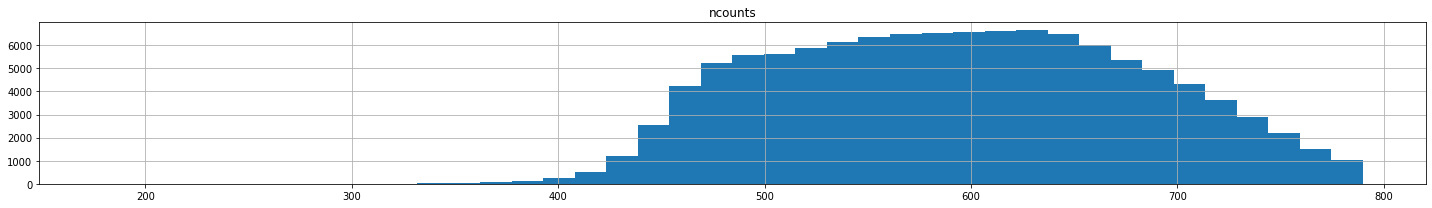

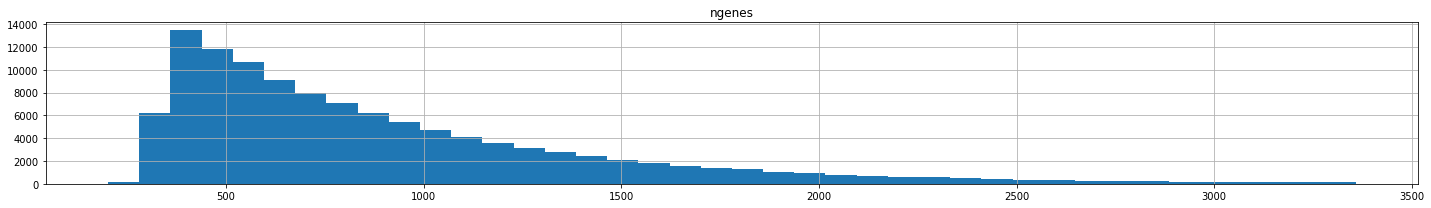

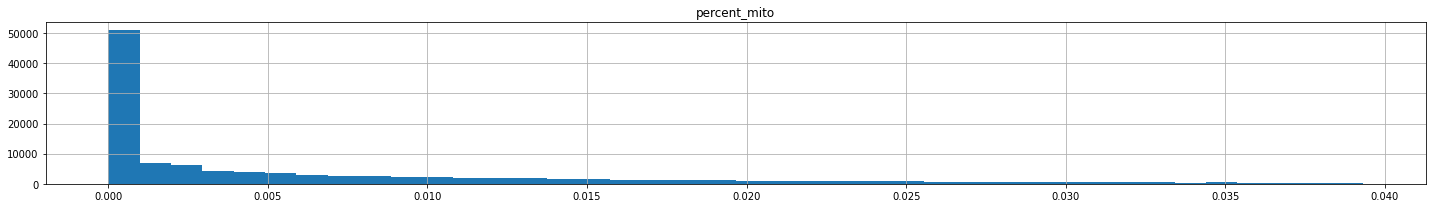

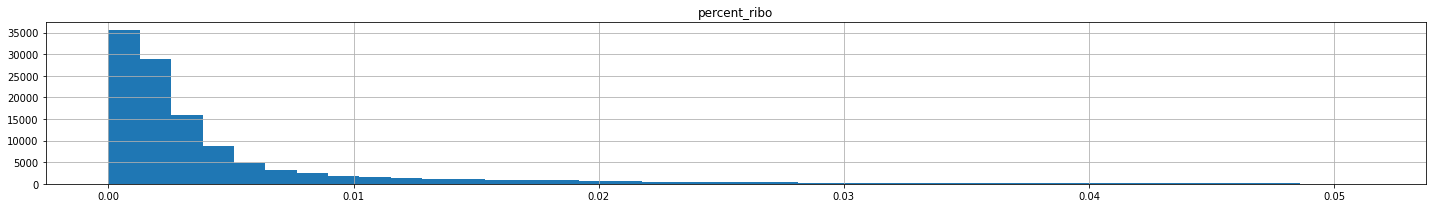

In [40]:
obs_hist(adata, ['ncounts', 'ngenes', 'percent_mito', 'percent_ribo'])

In [42]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata)
scv.pp.pca(adata, use_highly_variable=True)
scv.pp.neighbors(adata)
scv.tl.umap(adata)

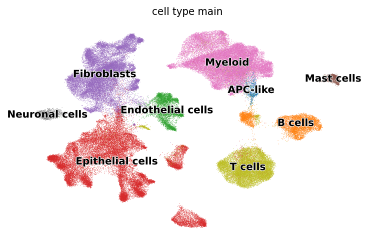

In [43]:
scv.pl.scatter(adata, color='cell_type_main')

In [44]:
adata.write('data/MelmsIzar290421/MelmsIzar290421.h5')

## MoMas

In [369]:
mdata = adata[adata.obs.cell_type_main=='Myeloid'].copy()
sc.pp.highly_variable_genes(mdata)
scv.pp.pca(mdata, use_highly_variable=True)
scv.pp.neighbors(mdata)
scv.tl.umap(mdata)
mdata.write('data/MelmsIzar290421/MelmsIzar290421_macrophages.h5')

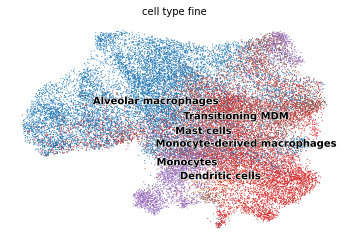

In [371]:
scv.pl.scatter(mdata, color='cell_type_fine')

In [144]:
adata.write(f'{path}/BostBronte050321.h5')

# ChuaEils290620

Note: Clinical annotation of samples is here as pdf file
https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-020-0602-4/MediaObjects/41587_2020_602_MOESM1_ESM.pdf

In [3]:
path = '/fast/work/projects/bluethgen_landthaler/Cov19_Hamster/data/ExternalData/ChuaEils290620/'

In [4]:
# load count matrices (10mins)
adatas = {}
for sample in tqdm(get_subfolders(f'{path}/raw_matrices/', False)):
    adata = sc.read_10x_mtx(f'{path}/raw_matrices/{sample}/')
    adata.obs_names = [x.split('-')[0] for x in adata.obs_names]
    adatas[sample] = adata

100%|██████████| 36/36 [10:15<00:00, 17.09s/it]


In [6]:
tab = pd.read_csv(f'{path}seurat_metadata.csv', index_col=0)
print(np.sum(tab.index.duplicated()), ' barcodes are duplicated')
tab

0  barcodes are duplicated


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,patient,sample,location,series,infection,sex,age,celltype,severity,dps,virus_pos
AAACGAACAGACAAGC_1_1_1,covid,65407.272913,3452,0.000000,BIH-CoV-11,BIH-CoV-11_NS_1,NS,1,SARS-CoV-2,m,61,Squamous,critical,11,0
AAACGAAGTCCTCAGG_1_1_1,covid,3302.145119,828,0.000000,BIH-CoV-11,BIH-CoV-11_NS_1,NS,1,SARS-CoV-2,m,61,nrMa,critical,11,0
AAACGCTAGGCACTCC_1_1_1,covid,1192.757785,414,0.722847,BIH-CoV-11,BIH-CoV-11_NS_1,NS,1,SARS-CoV-2,m,61,Neu,critical,11,0
AAACGCTCACTATGTG_1_1_1,covid,977.715295,498,1.801254,BIH-CoV-11,BIH-CoV-11_NS_1,NS,1,SARS-CoV-2,m,61,nrMa,critical,11,0
AAACGCTGTGAGTTTC_1_1_1,covid,7558.334737,1971,1.734418,BIH-CoV-11,BIH-CoV-11_NS_1,NS,1,SARS-CoV-2,m,61,nrMa,critical,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCATCGTTCC_4_2,covid,82384.155568,7313,4.245606,BIH-CoV-04,BIH-CoV-04_NS_1,NS,1,SARS-CoV-2,m,73,nrMa,critical,13,0
TTTGTTGGTGGATTTC_4_2,covid,1541.777778,646,0.414919,BIH-CoV-04,BIH-CoV-04_NS_1,NS,1,SARS-CoV-2,m,73,moDC,critical,13,0
TTTGTTGTCCTGCCAT_4_2,covid,3190.338669,1057,1.068858,BIH-CoV-04,BIH-CoV-04_NS_1,NS,1,SARS-CoV-2,m,73,Neu,critical,13,0
TTTGTTGTCGTGTCAA_4_2,covid,4566.227849,1904,4.619124,BIH-CoV-04,BIH-CoV-04_NS_1,NS,1,SARS-CoV-2,m,73,CTL,critical,13,0


In [11]:
tab.value_counts(['sample', 'series'])

sample           series
BIH-CoV-15_NS_1  1         20622
BIH-CoV-15_NS_2  2          9964
BIH-CoV-01_NS_1  1          9723
BIH-CoV-12_NS_1  1          8620
BIH-CoV-15_NS_4  4          7903
BIH-CoV-14_NS_2  2          7342
BIH-CoV-07_NS_2  2          7041
BIH-CoV-15_NS_3  3          6636
BIH-CoV-06_NS_2  2          6629
BIH-CoV-12_NS_3  3          5908
BIH-CoV-07_NS_1  1          5723
BIH-CoV-06_NS_1  1          4899
BIH-CoV-16_NS_1  1          4759
BIH-CoV-04_NS_1  1          3927
BIH-CoV-17_NS_1  1          3553
BIH-CoV-12_NS_2  2          3224
BIH-CoV-11_NS_1  1          3054
BIH-CoV-10_NS_1  1          2624
BIH-CoV-05_NS_1  1          1934
BIH-CoV-09_NS_1  1          1494
BIH-CoV-19_NS_1  1          1421
BIH-CoV-02_NS_1  1          1208
BIH-CoV-14_NS_1  1          1179
BIH-CoV-13_NS_1  1          1080
BIH-Con-01_NS_1  1          1037
BIH-Con-03_NS_1  1           968
BIH-CoV-03_NS_1  1           828
BIH-CoV-08_NS_1  1           720
BIH-CoV-18_NS_1  1           603
BIH-Con-02_NS_1  1 

In [4]:
# load metadata
tab = pd.read_csv(f'{path}seurat_metadata.csv', index_col=0)
# correct mixup
translate_tab_to_adata = {
    'BIH-Con-02_NS_1' : 'BIH-Con-01_NS_2',
    'BIH-Con-03_NS_1' : 'BIH-Con-01_NS_3',
    'BIH-Con-04_NS_1' : 'BIH-Con-01_NS_4',
    'BIH-Con-05_NS_1' : 'BIH-Con-01_NS_5',
}
tab['sample'] = tab['sample'].replace(translate_tab_to_adata)
tab.index = [x.split('_')[0]+'-'+sample for x, sample in zip(tab.index, tab['sample'])]  # clear barcode and add sample name to it
print(np.sum(tab.index.duplicated()), ' barcodes are duplicated')
tab = tab[~tab.index.duplicated(keep="first")]

484  barcodes are duplicated


In [5]:
adata = sc.concat(adatas, index_unique='-', label='sample')
obs = pd.concat([adata.obs, tab.drop('sample', axis=1)], axis=1)
adata.obs = obs.loc[adata.obs_names]
adata.obs.location = [x.split('_')[-2] for x in adata.obs_names]

In [6]:
adata

AnnData object with n_obs × n_vars = 227418 × 32754
    obs: 'sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'patient', 'location', 'series', 'infection', 'sex', 'age', 'celltype', 'severity', 'dps', 'virus_pos'

In [11]:
# transfer sample-level annotation to cells without metadata in seurat object
for sample in pd.unique(adata.obs['sample']):
    for key in ['patient', 'location', 'infection', 'sex', 'age', 'severity', 'dps']:
        unique = pd.unique(adata.obs[adata.obs['sample']==sample][key])
        unique = unique[~pd.isna(unique)]
        if len(unique)>0:
            adata.obs.loc[adata.obs['sample']==sample, key] = unique[0]

In [60]:
# I think either me or them made a mistake with naming the files, what a shame.
# samples without metadata
adata_samples = np.array(pd.unique(adata.obs['sample']))
tab_samples = np.array(pd.unique(tab['sample']))

# Samples without annotation
adata_samples[~np.isin(adata_samples, tab_samples)]
# -> array(['BIH-CoV-04_PB_1', 'BIH-Con-01_NS_2', 'BIH-Con-01_NS_4',
#        'BIH-CoV-01_PB_1', 'BIH-Con-01_NS_3', 'BIH-CoV-04_BL_1',
#        'BIH-CoV-01_BL_1', 'BIH-Con-01_NS_5'], dtype=object)

# Annotations with no cells
tab_samples[~np.isin(tab_samples, adata_samples)];
# -> array(['BIH-Con-02_NS_1', 'BIH-Con-03_NS_1', 'BIH-Con-04_NS_1',
#        'BIH-Con-05_NS_1'], dtype=object)

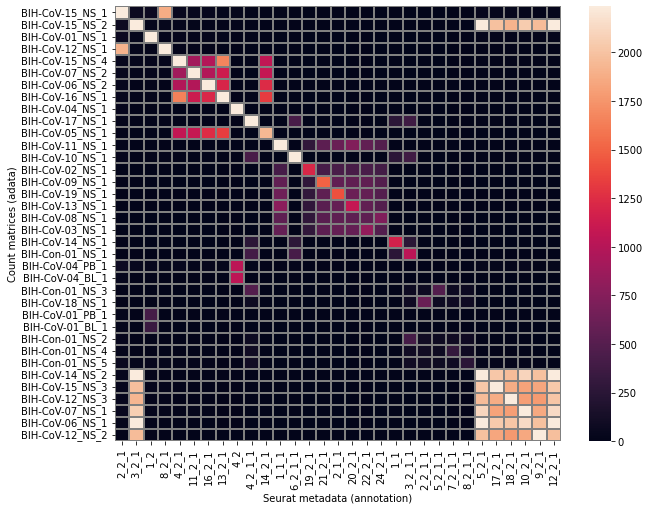

In [134]:
tab = pd.read_csv(f'{path}seurat_metadata.csv', index_col=0)
tab['addendum'] = [x.split('_', 1)[1] for x in tab.index]
tab.index = [x.split('_')[0]+'-'+sample for x, sample in zip(tab.index, tab['sample'])]  # clear barcode and add sample name to it
bco = identify_barcode_overlap(adata.obs, tab, 'sample', 'addendum', plot=False)
# this looks baaaaad
pl.figure(figsize=[10,8])
bco = cluster_matrix(bco, 'both')
sns.heatmap(bco, robust=True, linewidth=0.005, linecolor='grey')
pl.ylabel('Count matrices (adata)')
pl.xlabel('Seurat metadata (annotation)')
pl.show()

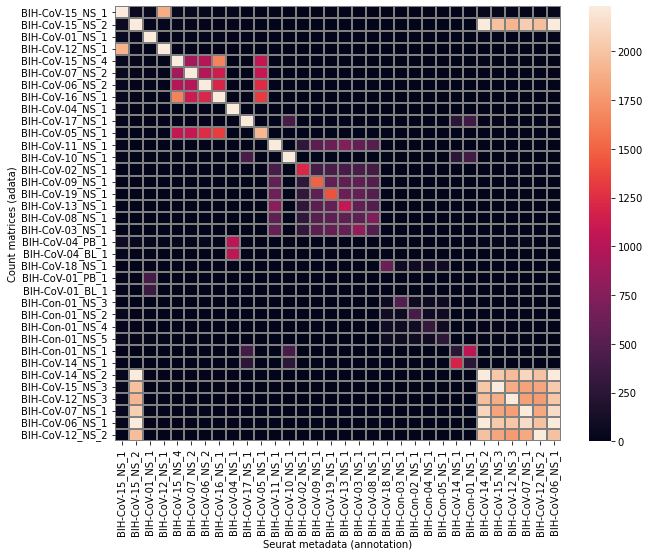

In [122]:
tab = pd.read_csv(f'{path}seurat_metadata.csv', index_col=0)
tab.index = [x.split('_')[0]+'-'+sample for x, sample in zip(tab.index, tab['sample'])]  # clear barcode and add sample name to it
bco = identify_barcode_overlap(adata.obs, tab, 'sample', 'sample', plot=False)
# this looks baaaaad
pl.figure(figsize=[10,8])
bco = cluster_matrix(bco, 'both')
sns.heatmap(bco, robust=True, linewidth=0.005, linecolor='grey')
pl.ylabel('Count matrices (adata)')
pl.xlabel('Seurat metadata (annotation)')
pl.show()

In [12]:
calc_qc(adata)

In [13]:
adata.obs

,sample,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,patient,location,series,infection,sex,age,celltype,severity,dps,virus_pos,ncounts,ngenes,percent_mito,percent_ribo,percent_hemo
AAACCCAAGATACGAT-BIH-CoV-10_NS_1,BIH-CoV-10_NS_1,covid,7037.000000,2200.0,5.968452,BIH-CoV-10,NS,1.0,SARS-CoV-2,m,68.0,B cell,critical,20.0,0.0,7037.0,2200,5.968452,30.353844,0.0
AAACCCAAGCAGTCTT-BIH-CoV-10_NS_1,BIH-CoV-10_NS_1,NaN,NaN,NaN,NaN,BIH-CoV-10,NS,NaN,SARS-CoV-2,m,68.0,NaN,critical,20.0,NaN,2130.0,1091,19.624413,6.713615,0.0
AAACGAAAGCTTTCTT-BIH-CoV-10_NS_1,BIH-CoV-10_NS_1,covid,46202.000000,5659.0,2.958746,BIH-CoV-10,NS,1.0,SARS-CoV-2,m,68.0,Squamous,critical,20.0,0.0,46204.0,5661,2.958618,2.783309,0.0
AAACGAACAACCGACC-BIH-CoV-10_NS_1,BIH-CoV-10_NS_1,NaN,NaN,NaN,NaN,BIH-CoV-10,NS,NaN,SARS-CoV-2,m,68.0,NaN,critical,20.0,NaN,5997.0,409,86.376518,1.217275,0.0
AAACGAAGTCGCTTGG-BIH-CoV-10_NS_1,BIH-CoV-10_NS_1,covid,643.000000,321.0,2.799378,BIH-CoV-10,NS,1.0,SARS-CoV-2,m,68.0,Squamous,critical,20.0,0.0,643.0,321,2.799378,2.177294,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGACTGTGATTAGA-BIH-CoV-03_NS_1,BIH-CoV-03_NS_1,covid,988.689961,659.0,0.000000,BIH-CoV-03,NS,1.0,SARS-CoV-2,m,52.0,B cell,critical,10.0,0.0,1274.0,736,2.511774,21.350079,0.0
TTTGGAGCAATACGAA-BIH-CoV-03_NS_1,BIH-CoV-03_NS_1,covid,36014.553921,6050.0,0.015755,BIH-CoV-03,NS,1.0,SARS-CoV-2,m,52.0,Squamous,critical,10.0,0.0,42311.0,6584,2.042022,5.265770,0.0
TTTGGTTTCGCATTGA-BIH-CoV-03_NS_1,BIH-CoV-03_NS_1,covid,895.680043,316.0,0.000000,BIH-CoV-03,NS,1.0,SARS-CoV-2,m,52.0,Squamous,critical,10.0,0.0,1044.0,340,1.340996,4.789272,0.0
TTTGTTGCACTCCGGA-BIH-CoV-03_NS_1,BIH-CoV-03_NS_1,NaN,NaN,NaN,NaN,BIH-CoV-03,NS,NaN,SARS-CoV-2,m,52.0,NaN,critical,10.0,NaN,3309.0,323,71.290421,0.967060,0.0


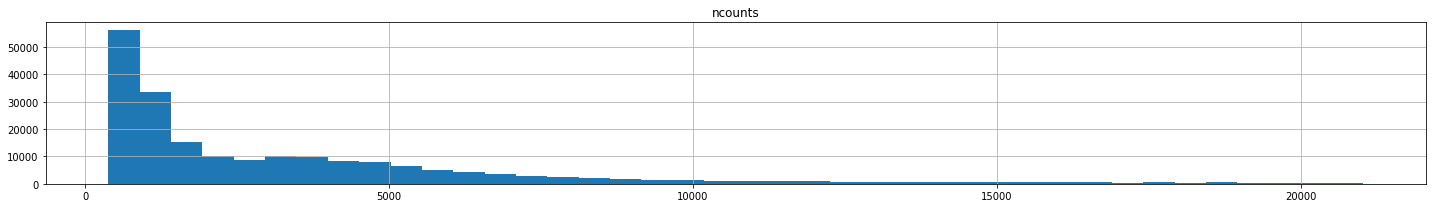

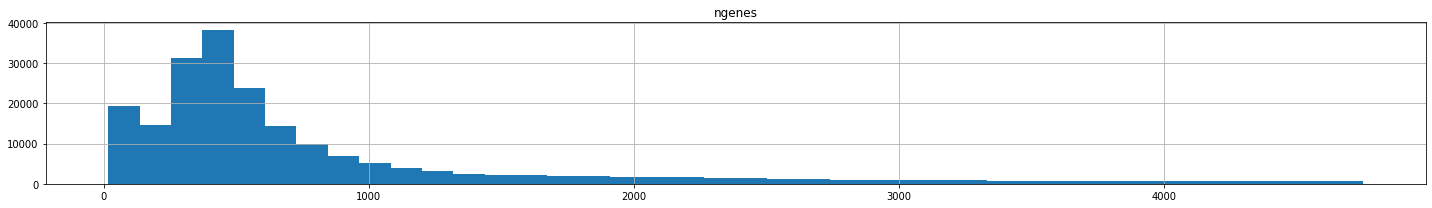

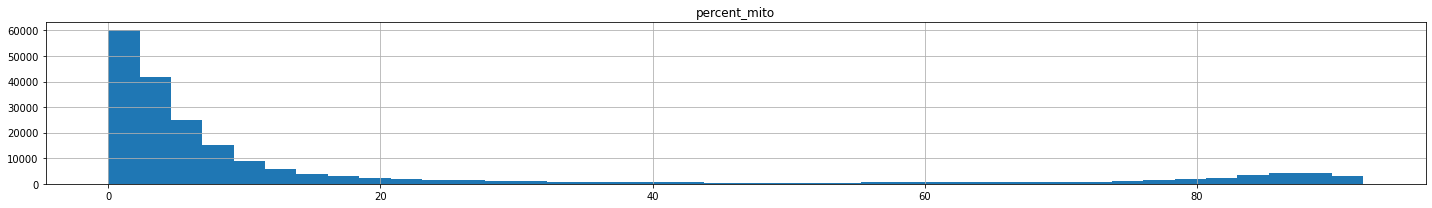

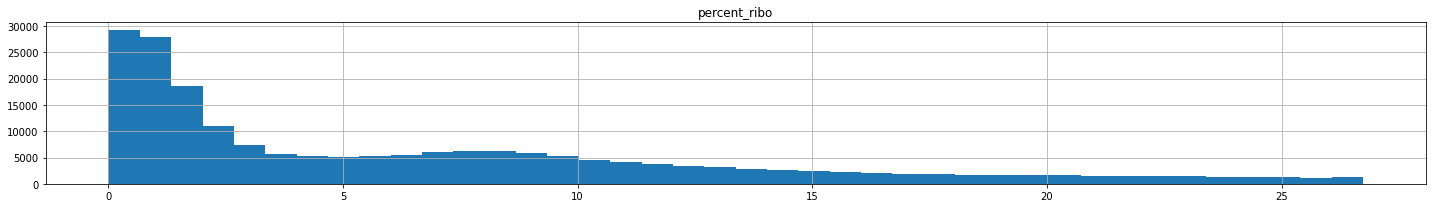

In [14]:
obs_hist(adata, ['ncounts', 'ngenes', 'percent_mito', 'percent_ribo'], range_perc=[0, 90])

In [15]:
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_cells(adata, max_counts=30000)
sc.pp.filter_cells(adata, min_genes=200)
adata = filter_mito(adata, max_percentage=30)

In [16]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, batch_key='sample')
scv.pp.pca(adata, use_highly_variable=True)
scv.pp.neighbors(adata)
scv.tl.umap(adata)

... storing 'orig.ident' as categorical
... storing 'patient' as categorical
... storing 'location' as categorical
... storing 'infection' as categorical
... storing 'sex' as categorical
... storing 'celltype' as categorical
... storing 'severity' as categorical


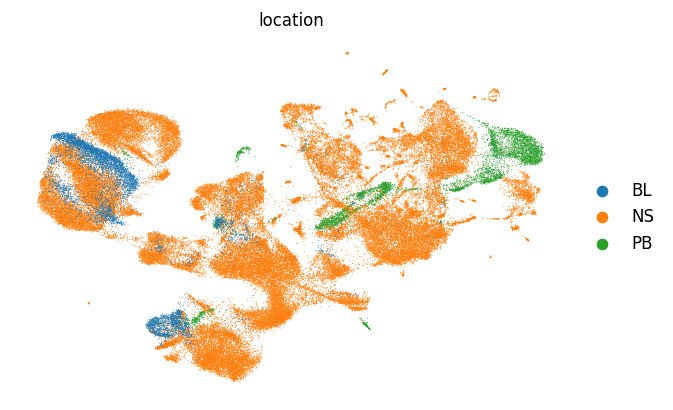

In [17]:
scv.pl.scatter(adata, color='location', dpi=120, legend_loc='right margin')

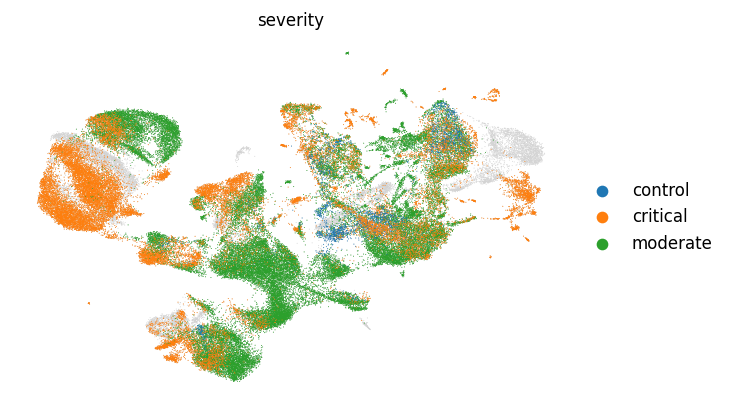

In [19]:
scv.pl.scatter(adata, color='severity', dpi=120, legend_loc='right margin')

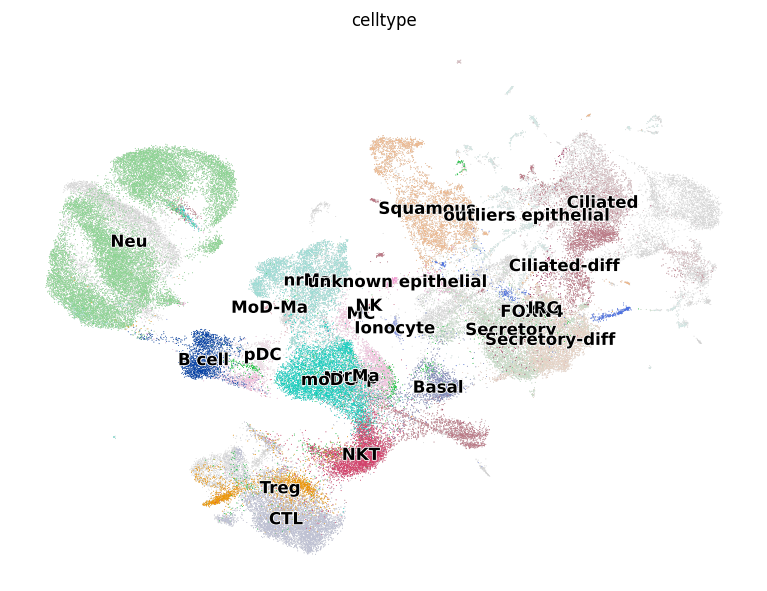

In [20]:
scv.pl.scatter(adata, color='celltype', dpi=120, legend_loc='on data', figsize=[8,6])

In [21]:
adata.write(f'{path}/ChuaEils290620.h5')

# Spacers